Import Block

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-daging-sapi-malang-2017-2021.csv?token=ARB4LTAY5MGQWZXBFF3SJG3AX3EZY \
    -O /tmp/meat.csv

--2021-06-01 01:49:02--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-daging-sapi-malang-2017-2021.csv?token=ARB4LTAY5MGQWZXBFF3SJG3AX3EZY
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16898 (17K) [text/plain]
Saving to: ‘/tmp/meat.csv’

/tmp/meat.csv       100%[===================>]  16.50K  --.-KB/s    in 0s      

2021-06-01 01:49:03 (102 MB/s) - ‘/tmp/meat.csv’ saved [16898/16898]



In [3]:
#Read dataset with pandas, then put it to meat_df variable
meat_df = pd.read_csv('/tmp/meat.csv')
meat_df

tanggal   harga
0    2017-08-02  110000
1    2017-08-03  110000
2    2017-08-04  110000
3    2017-08-07  110000
4    2017-08-08  110000
..          ...     ...
933  2021-05-24  107500
934  2021-05-25  107500
935  2021-05-27  107500
936  2021-05-28  107500
937  2021-05-31  107500

[938 rows x 2 columns]

In [4]:
#Inspect the first 5 of meat_df dataframe
meat_df.head()

tanggal   harga
0  2017-08-02  110000
1  2017-08-03  110000
2  2017-08-04  110000
3  2017-08-07  110000
4  2017-08-08  110000

In [5]:
#Inspect the last 5 of meat_df dataframe
meat_df.tail()

tanggal   harga
933  2021-05-24  107500
934  2021-05-25  107500
935  2021-05-27  107500
936  2021-05-28  107500
937  2021-05-31  107500

In [6]:
#Inspect the describtion of meat_df dataframe
meat_df.describe()

harga
count     938.000000
mean   107542.643923
std      2826.501026
min    102500.000000
25%    105000.000000
50%    105000.000000
75%    110000.000000
max    120000.000000

In [7]:
#Casting harga's column to float
meat_df['harga'] = pd.to_numeric(meat_df['harga'], downcast='float')
meat_df

tanggal     harga
0    2017-08-02  110000.0
1    2017-08-03  110000.0
2    2017-08-04  110000.0
3    2017-08-07  110000.0
4    2017-08-08  110000.0
..          ...       ...
933  2021-05-24  107500.0
934  2021-05-25  107500.0
935  2021-05-27  107500.0
936  2021-05-28  107500.0
937  2021-05-31  107500.0

[938 rows x 2 columns]

In [8]:
#Normalize harga's column data by dividing it with the largest number
max = meat_df['harga'].max()
meat_df['harga'] /= max
meat_df

tanggal     harga
0    2017-08-02  0.916667
1    2017-08-03  0.916667
2    2017-08-04  0.916667
3    2017-08-07  0.916667
4    2017-08-08  0.916667
..          ...       ...
933  2021-05-24  0.895833
934  2021-05-25  0.895833
935  2021-05-27  0.895833
936  2021-05-28  0.895833
937  2021-05-31  0.895833

[938 rows x 2 columns]

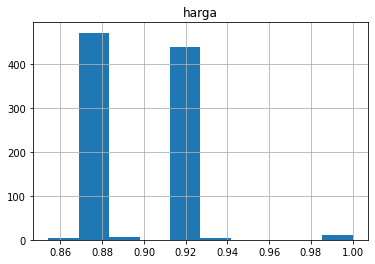

In [9]:
_ = meat_df.hist()

In [10]:
#Get the price and time step from dataframe
temp = meat_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [11]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

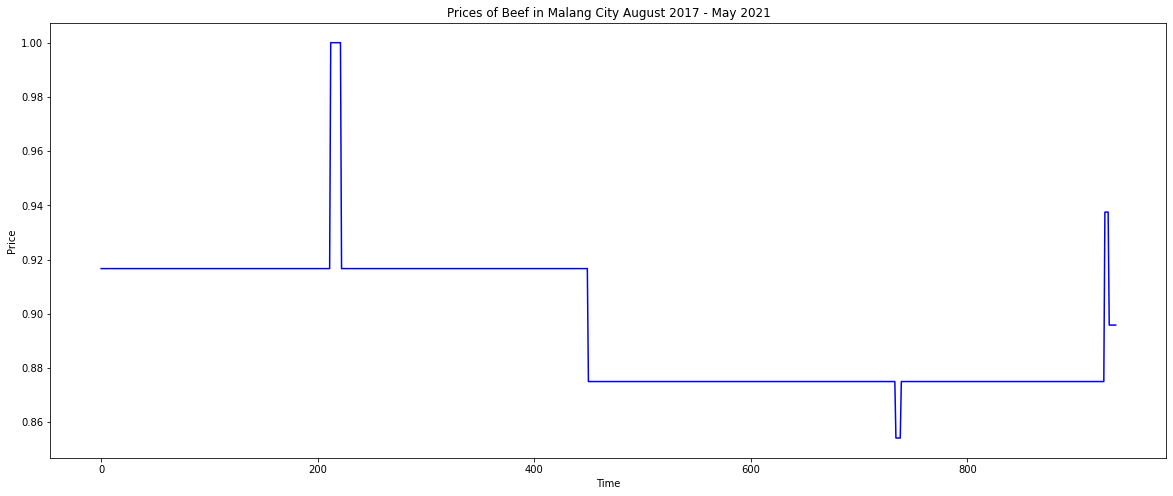

In [12]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Beef in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

Split Train & Test


In [13]:
#Split dataset with 75% of training, 15% for validation, and the rest for testing
split = round(0.75*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

Windowing the Dataset

In [14]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [15]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  print(data_forecast)
  forecast = model.predict(data_forecast)
  return forecast

Window Size, Batch Size, & Shuffle Buffer Variable

In [16]:
window_size = 10
batch_size = 512
shuffle_buffer = 950

Build the Model

In [17]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=150, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(704,)
Epoch 1/150
2/2 [==============================] - 33s 67ms/step - loss: 0.4301 - mean_absolute_error: 0.9271
Epoch 2/150
2/2 [==============================] - 0s 17ms/step - loss: 0.4301 - mean_absolute_error: 0.9271
Epoch 3/150
2/2 [==============================] - 0s 11ms/step - loss: 0.4301 - mean_absolute_error: 0.9271
Epoch 4/150
2/2 [==============================] - 0s 16ms/step - loss: 0.4301 - mean_absolute_error: 0.9271
Epoch 5/150
2/2 [==============================] - 0s 11ms/step - loss: 0.4301 - mean_absolute_error: 0.9271
Epoch 6/150
2/2 [==============================] - 0s 16ms/step - loss: 0.4301 - mean_absolute_error: 0.9271
Epoch 7/150
2/2 [==============================] - 0s 12ms/step - loss: 0.4301 - mean_absolute_error: 0.9271
Epoch 8/150
2/2 [==============================] - 0s 11ms/step - loss: 0.4301 - mean_absolute_error: 0.9271
Epoch 9/150
2/2 [=========

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 16)          528       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 9,057
Trainable params: 9,057
Non-trainable params: 0
_________________________________________________________________


(1e-05, 0.1, 0.0, 0.2)

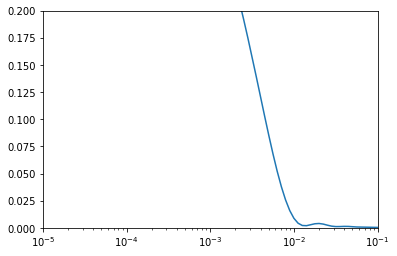

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.2])

In [21]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=150, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(704,)
Epoch 1/150
2/2 [==============================] - 2s 447ms/step - loss: 0.2657 - mean_absolute_error: 0.7147 - val_loss: 0.0314 - val_mean_absolute_error: 0.2033
Epoch 2/150
2/2 [==============================] - 0s 93ms/step - loss: 0.0354 - mean_absolute_error: 0.2231 - val_loss: 0.1390 - val_mean_absolute_error: 0.4734
Epoch 3/150
2/2 [==============================] - 0s 114ms/step - loss: 0.1411 - mean_absolute_error: 0.4821 - val_loss: 0.0585 - val_mean_absolute_error: 0.3057
Epoch 4/150
2/2 [==============================] - 0s 98ms/step - loss: 0.0351 - mean_absolute_error: 0.2140 - val_loss: 0.0114 - val_mean_absolute_error: 0.1396
Epoch 5/150
2/2 [==============================] - 0s 94ms/step - loss: 0.0227 - mean_absolute_error: 0.1970 - val_loss: 0.0513 - val_mean_absolute_error: 0.3194
Epoch 6/150
2/2 [==============================] - 0s 90ms/step - loss: 0.0497 - mean_a

In [22]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


array([0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709836,
       0.89709836, 0.89709836, 0.89709836, 0.89709836, 0.89709

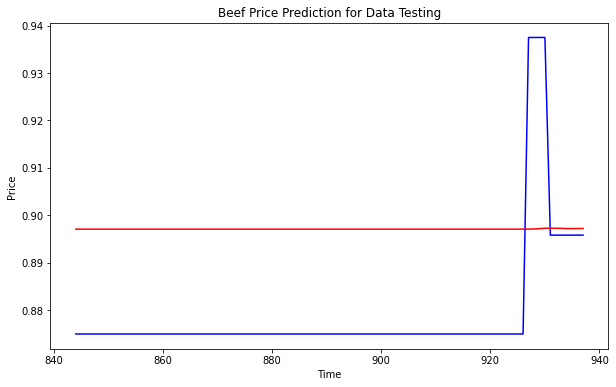

In [23]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Beef Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Beef Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

<Figure size 432x288 with 0 Axes>

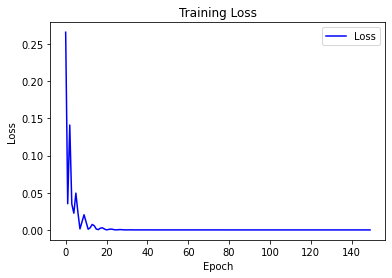

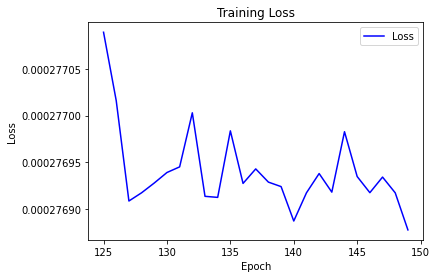

<Figure size 432x288 with 0 Axes>

In [25]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[125:]
epoch_num_zoom = [x+125 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

In [26]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [27]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


[[[0.8953873515129089],
  [0.8949477672576904],
  [0.8956236243247986],
  [0.8956459164619446],
  [0.8959745764732361],
  [0.896280825138092],
  [0.8965466022491455],
  [0.896769642829895],
  [0.8969522714614868],
  [0.8970983624458313],
  [0.8972606658935547],
  [0.8974050283432007],
  [0.8975583910942078],
  [0.8976082801818848],
  [0.8976293802261353],
  [0.8976317048072815],
  [0.897601842880249],
  [0.8976202011108398],
  [0.8976210355758667],
  [0.8976185321807861]]]

In [28]:
round(rnn_forecast[-1][-1][0]*max)

107714

In [29]:
model.save("meat_model")

INFO:tensorflow:Assets written to: meat_model/assets


INFO:tensorflow:Assets written to: meat_model/assets


In [30]:
!zip -r meat_model.zip meat_model

  adding: meat_model/ (stored 0%)
  adding: meat_model/assets/ (stored 0%)
  adding: meat_model/keras_metadata.pb (deflated 89%)
  adding: meat_model/saved_model.pb (deflated 90%)
  adding: meat_model/variables/ (stored 0%)
  adding: meat_model/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: meat_model/variables/variables.index (deflated 63%)
